# Lab 6: Variable Selection and Regularization

## Part I: Different Model Specs
### A. Regression without regularization
1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression

In [16]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, make_scorer, mean_squared_error
from sklearn.compose import ColumnTransformer
import warnings
from sklearn.exceptions import ConvergenceWarning
# Suppress ConvergenceWarning and other warnings from sklearn
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [17]:
hitters = pd.read_csv(r"C:\Users\achur\OneDrive\Desktop\School\CP Fall 2024\544\Hitters.csv")

In [18]:
from sklearn.compose import make_column_selector
def regression_analysis(X, y, model_type = "linear", alpha_values = [0.001, 0.01, 0.1, 1, 10], l1_ratio_values = [0.0, 0.25, 0.5, 0.75, 1.0], cv = 5):
    if model_type == "linear":
        model = LinearRegression()
        alpha = {}
        l1_ratio = {}
    elif model_type == "ridge":
        model = Ridge()
        alpha = {"regression__alpha": alpha_values}
        l1_ratio = {}
    elif model_type == "lasso":
        model = Lasso()
        alpha = {"regression__alpha": alpha_values}
        l1_ratio = {}
    elif model_type == "elastic_net":
        model = ElasticNet()
        alpha = {"regression__alpha": alpha_values, "regression__l1_ratio": l1_ratio_values}
    else:
        raise ValueError("Error")

    # pipeline
    ct = ColumnTransformer([("dummify", OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
                                        make_column_selector(dtype_include=object)),
                            ("standardize", StandardScaler(),
                                        make_column_selector(dtype_include=np.number))],
                                        remainder = "passthrough")

    pipeline = Pipeline([
        ("preprocessing", ct),
        ("regression", model)
    ])

    # grid search
    grid_search = GridSearchCV(pipeline, alpha, cv=cv, scoring="neg_mean_squared_error")
    grid_search_fitted = grid_search.fit(X, y)

    # best model
    best_model = grid_search.best_estimator_
    best_model_fitted = best_model.fit(X, y)

    # coefficients
    coefs = best_model.named_steps["regression"].coef_
    feature_names = best_model_fitted.named_steps["preprocessing"].get_feature_names_out()

    # data frame
    coefs_df = pd.DataFrame({
        "Feature Name": feature_names,
        "Coefficients": coefs})

    print("Cross-validated MSE scores:", -grid_search_fitted.cv_results_["mean_test_score"])

    # best model values
    best_alpha = grid_search.best_params_.get("regression__alpha", None)
    best_l1_ratio = grid_search.best_params_.get("regression__l1_ratio", None)
    best_score = grid_search.best_score_

    # print best alpha and l1 ratio
    if best_alpha is not None:
        print(f"Best alpha: {best_alpha}")
    if best_l1_ratio is not None:
        print(f"Best l1 ratio: {best_l1_ratio}")
    print(f"Best cross-validated MSE score: {-best_score}")

    return coefs_df

X = hitters.drop(columns=['Salary'])
y = hitters['Salary']
X = X[y.notna()]
y = y[y.notna()]

2. Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.
3. Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries

In [19]:
print("----- Linear Regression -----")
coefs_linear = regression_analysis(X, y, model_type="linear")
print(coefs_linear)

----- Linear Regression -----
Cross-validated MSE scores: [120548.42849608]
Best cross-validated MSE score: 120548.42849608236
            Feature Name  Coefficients
0      dummify__League_A    -31.299712
1      dummify__League_N     31.299712
2    dummify__Division_E     58.424623
3    dummify__Division_W    -58.424623
4   dummify__NewLeague_A     12.381163
5   dummify__NewLeague_N    -12.381163
6     standardize__AtBat   -291.094556
7      standardize__Hits    337.830479
8     standardize__HmRun     37.853837
9      standardize__Runs    -60.572479
10      standardize__RBI    -26.994984
11    standardize__Walks    135.073897
12    standardize__Years    -16.693359
13   standardize__CAtBat   -391.038655
14    standardize__CHits     86.687617
15   standardize__CHmRun    -14.181723
16    standardize__CRuns    480.747135
17     standardize__CRBI    260.689886
18   standardize__CWalks   -213.892259
19  standardize__PutOuts     78.761296
20  standardize__Assists     53.732490
21   standardiz

Interpretation of coefficients: The variable CRuns represents the relationship between total number of runs throughout the career and salary. This means that with each additional career run, the predicted salary is expected to increase by 480.74 units. The variable Hits represents the relationship between the number of hits in a season and salary. This means that with each additional hit in a season, the predicted salary is expected to increase by 337.83 units. The variable CRBI represents the relationship between total number of runs batted in in a career and salary. This means that with every additional RBI in a career, salary is expected to increase by 260.689 units. All expected increases are assuming keeping all other variables constant. 

### B. Ridge regression
1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression.
2. Use cross-validation to tune the lambda hyperparameter.
3. Fit the pipeline with your chosen lambda to the full dataset, and interpret a few of the most important coefficients.
4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [20]:
# Ridge Regression (with alpha hyperparameter tuning)
print("\n----- Ridge Regression -----")
coefs_ridge = regression_analysis(X, y, model_type="ridge")
print(coefs_ridge)


----- Ridge Regression -----


----- Ridge Regression -----


Cross-validated MSE scores: [121124.45859214 121022.90328584 120343.62106698 119144.43267692
 119348.9847757 ]
Best alpha: 1
Best cross-validated MSE score: 119144.4326769158
            Feature Name  Coefficients
0      dummify__League_A    -30.438855
1      dummify__League_N     30.438855
2    dummify__Division_E     60.015595
3    dummify__Division_W    -60.015595
4   dummify__NewLeague_A     13.111282
5   dummify__NewLeague_N    -13.111282
6     standardize__AtBat   -270.686441
7      standardize__Hits    296.645050
8     standardize__HmRun     18.100592
9      standardize__Runs    -29.339406
10      standardize__RBI     -9.113295
11    standardize__Walks    124.407173
12    standardize__Years    -38.667748
13   standardize__CAtBat   -225.406548
14    standardize__CHits    126.659607
15   standardize__CHmRun     39.070924
16    standardize__CRuns    320.412169
17     standardize__CRBI    160.386784
18   standardize__CWalks   -184.423611
19  standardize__PutOuts     78.623656
20  st

Interpretation of coefficients: The variable CRuns represents the relationship between total number of runs throughout the career and salary. This means that with each additional career run, the predicted salary is expected to increase by 320.41 units. The variable Hits represents the relationship between the number of hits in a season and salary. This means that with each additional hit in a season, the predicted salary is expected to increase by 296.645 units. The variable CRBI represents the relationship between total number of runs batted in in a career and salary. This means that with every additional RBI in a career, salary is expected to increase by 160.387 units. All expected increases are assuming keeping all other variables constant. 

### C. Lasso Regression
1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression.
2. Use cross-validation to tune the lambda hyperparameter.
3. Fit the pipeline with your chosen lambda to the full dataset, and interpret a few of the most important coefficients.
4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [21]:
# Lasso Regression (with alpha hyperparameter tuning)
print("\n----- Lasso Regression -----")
coefs_lasso = regression_analysis(X, y, model_type="lasso")
print(coefs_lasso)


----- Lasso Regression -----


----- Lasso Regression -----


Cross-validated MSE scores: [120994.17981481 120964.76468618 120682.25263745 119761.58740741
 121828.14133339]
Best alpha: 1
Best cross-validated MSE score: 119761.58740741303
            Feature Name  Coefficients
0      dummify__League_A -3.582607e+01
1      dummify__League_N  1.734720e-15
2    dummify__Division_E  1.144130e+02
3    dummify__Division_W -2.191014e-11
4   dummify__NewLeague_A  0.000000e+00
5   dummify__NewLeague_N -0.000000e+00
6     standardize__AtBat -2.823710e+02
7      standardize__Hits  3.043595e+02
8     standardize__HmRun  1.112702e+01
9      standardize__Runs -2.496651e+01
10      standardize__RBI -0.000000e+00
11    standardize__Walks  1.206953e+02
12    standardize__Years -3.494815e+01
13   standardize__CAtBat -1.626398e+02
14    standardize__CHits  0.000000e+00
15   standardize__CHmRun  1.422599e+01
16    standardize__CRuns  3.755655e+02
17     standardize__CRBI  1.926109e+02
18   standardize__CWalks -1.896446e+02
19  standardize__PutOuts  7.876037e+01
20  s

Interpretation of coefficients: The variable PutOuts represents the relationship between the total number of put outs in a season and salary. This means that for each additional put out in a season, the expected salary is expected to increase by 7.876 units. The variable Assists represents the relationship between the total number of assists in a season and salary. This means that for each additional assist in a season, the expected salary is expected to increase by 4.1999 units. The variable CRuns represents the relationship between total number of runs in a career and salary. This means that for each additional run, the salary is expected to increase by 3.755 units. All expected increases are assuming keeping all other variables constant. 

### D. Elastic Net
1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression.
2. Use cross-validation to tune the lambda and alpha hyperparameters.
3. Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.
4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [22]:
# Elastic Net Regression (with alpha and l1_ratio hyperparameter tuning)
print("\n----- Elastic Net Regression -----")
coefs_elastic_net = regression_analysis(X, y, model_type="elastic_net")

# Sort the coefficients in descending order of their absolute values
coefs_elastic_net['Coefficient'] = coefs_elastic_net['Coefficients']
coefs_elastic_net_sorted = coefs_elastic_net.sort_values(by='Coefficient', ascending=False).drop(columns='Coefficient')

print(coefs_elastic_net_sorted)



----- Elastic Net Regression -----


----- Elastic Net Regression -----


Cross-validated MSE scores: [119911.32888951 120077.76864311 120296.21077347 120590.44872106
 120994.17981481 118957.96789175 119009.79955442 119123.79308625
 119404.65600998 120964.76468618 119805.47261377 119636.17022676
 119381.37557129 119036.41354271 120682.25263745 122029.76100625
 121374.33374621 120775.68540067 120356.59599777 119761.58740741
 150034.24612426 144021.73108229 136766.42534889 128407.50504979
 121828.14133339]
Best alpha: 0.01
Best l1 ratio: 0.0
Best cross-validated MSE score: 118957.96789174949
            Feature Name  Coefficients
7      standardize__Hits    249.932752
16    standardize__CRuns    226.828966
14    standardize__CHits    123.652433
17     standardize__CRBI    122.933345
11    standardize__Walks    111.867856
19  standardize__PutOuts     77.975918
2    dummify__Division_E     60.813166
15   standardize__CHmRun     55.646471
20  standardize__Assists     41.454945
1      dummify__League_N     29.055922
4   dummify__NewLeague_A     12.395109
8     sta

Interpretation of coefficients: The variable Hits represents the relationship between total hits in a season and salary. This means that for each additional hit in a season, the salary is expected to increase by 249.93 units. The variable CRuns represents the relationship between total number of runs in a career and salary. This means that with each additional run, the salary is expected to increase by 226.82 units. The variable CHits represents the relationship between total number of hits in a career and salary. This means that with each additional hit in a career, salary is expected to increase by 123.56 units. All expected increases are assuming keeping all other variables constant. 

## Part II. Variable Selection
Based on the above results, decide on:

* Which numeric variable is most important.

* Which five numeric variables are most important

* Which categorical variable is most important

For each of the four model specifications, compare the following possible feature sets:

1. Using only the one best numeric variable.

2. Using only the five best variables.

3. Using the five best numeric variables and their interactions with the one best categorical variable.

Report which combination of features and model performed best, based on the validation metric of MSE.

(Note: lambda and alpha must be re-tuned for each feature set.)

In [23]:
# combine all coefficients into one dataframe
combined_coefs = pd.concat([
    coefs_linear.assign(Model='linear'),
    coefs_ridge.assign(Model='ridge'),
    coefs_lasso.assign(Model='lasso'),
    coefs_elastic_net.assign(Model='elastic_net')
])

# absolute average coefficients for variables
combined_coefs['Absolute Coefficient'] = combined_coefs['Coefficients'].abs()
avg_coefs = combined_coefs.groupby('Feature Name')['Absolute Coefficient'].mean().reset_index()
avg_coefs = avg_coefs.sort_values(by='Absolute Coefficient', ascending=False)

# most important numeric and categorical variables
numeric_vars = avg_coefs[avg_coefs['Feature Name'].str.startswith('standardize__')]
categorical_vars = avg_coefs[avg_coefs['Feature Name'].str.startswith('dummify__')]

# variables again
most_important_numeric = numeric_vars.iloc[0]['Feature Name']
top_five_numeric = numeric_vars.head(5)['Feature Name'].tolist()
most_important_categorical = categorical_vars.iloc[0]['Feature Name']

print(f"Most important numeric variable: {most_important_numeric}")
print(f"Top five numeric variables: {top_five_numeric}")
print(f"Most important categorical variable: {most_important_categorical}")


Most important numeric variable: standardize__CRuns
Top five numeric variables: ['standardize__CRuns', 'standardize__Hits', 'standardize__AtBat', 'standardize__CAtBat', 'standardize__CWalks']
Most important categorical variable: dummify__Division_E
Most important numeric variable: standardize__CRuns
Top five numeric variables: ['standardize__CRuns', 'standardize__Hits', 'standardize__AtBat', 'standardize__CAtBat', 'standardize__CWalks']
Most important categorical variable: dummify__Division_E


In [24]:
# with standardized results

# feature sets
X_one_best_numeric = X[['CRuns']]
top_five_numeric_vars = ['CRuns', 'Hits', 'AtBat', 'CAtBat', 'CWalks']
X_five_best_numeric = X[top_five_numeric_vars]

# one-hot encode the most important categorical variable
X_categorical_dummies = pd.get_dummies(X['Division'], drop_first=True)
X_combined = pd.concat([X_five_best_numeric, X_categorical_dummies], axis=1)
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_with_interactions = poly.fit_transform(X_combined)

# models and hyperparameters
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet()
}

param_grids = {
    "Ridge": {"regressor__alpha": [0.001, 0.01, 0.1, 1, 10, 100]},
    "Lasso": {"regressor__alpha": [0.001, 0.01, 0.1, 1, 10, 100]},
    "ElasticNet": {"regressor__alpha": [0.001, 0.01, 0.1, 1, 10, 100], "regressor__l1_ratio": [0.1, 0.5, 0.7, 0.9, 1.0]}
}

def evaluate_model(X, y, model, param_grid=None):
    """
    Evaluate the given model using cross-validation with standardization.
    If param_grid is provided, perform hyperparameter tuning using GridSearchCV.
    """
    # pipeline with standardization
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])
    
    if param_grid:
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X, y)
        best_model = grid_search.best_estimator_
        best_mse = -grid_search.best_score_

        # best parameters
        best_params = grid_search.best_params_
        print(f"Best Params for {type(model).__name__}: {best_params}")
    else:
        mse_scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
        best_model = pipeline.fit(X, y)  
        best_mse = -np.mean(mse_scores)

    # coefficients 
    if hasattr(best_model.named_steps['regressor'], 'coef_'):
        print(f"Coefficients for {type(model).__name__}: {best_model.named_steps['regressor'].coef_}")
    
    return best_model, best_mse

# feature sets
feature_sets = {
    "One Best Numeric Variable": X_one_best_numeric,
    "Five Best Numeric Variables": X_five_best_numeric,
    "Five Best Numeric Variables + Interactions": X_with_interactions
}

results = []

for feature_set_name, X_set in feature_sets.items():
    print(f"\n--- Evaluating Feature Set: {feature_set_name} ---")
    for model_name, model in models.items():
        if model_name in param_grids:  
            best_model, mse = evaluate_model(X_set, y, model, param_grids[model_name])
        else:  
            best_model, mse = evaluate_model(X_set, y, model)
        
        # append results
        results.append({
            "Feature Set": feature_set_name,
            "Model": model_name,
            "MSE": mse
        })
        print(f"Model: {model_name}, MSE: {mse:.2f}")

# results
results_df = pd.DataFrame(results)
print("\n--- Comparison Results ---")
print(results_df.sort_values(by="MSE"))



--- Evaluating Feature Set: One Best Numeric Variable ---
Coefficients for LinearRegression: [253.3513921]
Model: Linear, MSE: 143812.94


--- Evaluating Feature Set: One Best Numeric Variable ---
Coefficients for LinearRegression: [253.3513921]
Model: Linear, MSE: 143812.94


Best Params for Ridge: {'regressor__alpha': 10}
Coefficients for Ridge: [244.07112133]
Model: Ridge, MSE: 143658.52
Best Params for Ridge: {'regressor__alpha': 10}
Coefficients for Ridge: [244.07112133]
Model: Ridge, MSE: 143658.52


Best Params for Lasso: {'regressor__alpha': 10}
Coefficients for Lasso: [243.3513921]
Model: Lasso, MSE: 143793.45
Best Params for Lasso: {'regressor__alpha': 10}
Coefficients for Lasso: [243.3513921]
Model: Lasso, MSE: 143793.45


Best Params for ElasticNet: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.5}
Coefficients for ElasticNet: [241.23942105]
Model: ElasticNet, MSE: 143655.08

--- Evaluating Feature Set: Five Best Numeric Variables ---
Coefficients for LinearRegression: [ 456.3196552   327.13530336 -196.70615925 -234.72104822   -4.06806169]
Model: Linear, MSE: 127649.37
Best Params for ElasticNet: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.5}
Coefficients for ElasticNet: [241.23942105]
Model: ElasticNet, MSE: 143655.08

--- Evaluating Feature Set: Five Best Numeric Variables ---
Coefficients for LinearRegression: [ 456.3196552   327.13530336 -196.70615925 -234.72104822   -4.06806169]
Model: Linear, MSE: 127649.37


Best Params for Ridge: {'regressor__alpha': 1}
Coefficients for Ridge: [ 380.50598283  307.14994708 -173.5620581  -171.16418186    7.99249969]
Model: Ridge, MSE: 126800.37
Best Params for Ridge: {'regressor__alpha': 1}
Coefficients for Ridge: [ 380.50598283  307.14994708 -173.5620581  -171.16418186    7.99249969]
Model: Ridge, MSE: 126800.37


Best Params for Lasso: {'regressor__alpha': 1}
Coefficients for Lasso: [ 392.70616194  302.97458863 -170.15481173 -175.40070569    0.        ]
Model: Lasso, MSE: 127187.74
Best Params for Lasso: {'regressor__alpha': 1}
Coefficients for Lasso: [ 392.70616194  302.97458863 -170.15481173 -175.40070569    0.        ]
Model: Lasso, MSE: 127187.74


Best Params for ElasticNet: {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.1}
Coefficients for ElasticNet: [ 316.22759555  283.20452797 -147.07471559 -117.16018984   17.95345744]
Model: ElasticNet, MSE: 126647.19

--- Evaluating Feature Set: Five Best Numeric Variables + Interactions ---
Coefficients for LinearRegression: [  495.25130177    12.32425889  -431.11624391  -228.41352921   132.25584063
   -45.02907867  3200.10568619 -3810.6313186    318.7258854    462.33687944
   331.61993502   468.12651316 -3182.19197512   220.56585276  -487.84977664
  3564.52051908   192.16838511   492.14969675 -1119.4943334   -226.92356699
  -101.07336084]
Model: Linear, MSE: 129296.23
Best Params for Ridge: {'regressor__alpha': 100}
Coefficients for Ridge: [ 34.84121929  22.69493939 -13.01586893  17.72730334  21.42745868  -8.57171215
  63.9794817   43.67892045 -19.38382253 -25.13093687  -0.81091932  39.85692869
  45.60281967  56.85423176 -18.62105091  26.96442216  34.37194974 -17.42964641
 -34.75047

Best Params for Lasso: {'regressor__alpha': 10}
Coefficients for Lasso: [ 15.66504447   0.          -0.           0.           0.          -0.
 229.20886962   0.          -0.          -0.          -0.          22.56503439
   0.         119.508054   -44.17255445   0.           0.          -0.
 -88.72706431  -0.          -0.        ]
Model: Lasso, MSE: 107952.27
Best Params for Lasso: {'regressor__alpha': 10}
Coefficients for Lasso: [ 15.66504447   0.          -0.           0.           0.          -0.
 229.20886962   0.          -0.          -0.          -0.          22.56503439
   0.         119.508054   -44.17255445   0.           0.          -0.
 -88.72706431  -0.          -0.        ]
Model: Lasso, MSE: 107952.27


Best Params for ElasticNet: {'regressor__alpha': 1, 'regressor__l1_ratio': 0.7}
Coefficients for ElasticNet: [ 37.45556875  21.49448061 -17.45156452  16.19595705  21.94174811  -6.9142774
  69.33192879  44.78454398 -21.30951693 -27.70756918  -0.          43.13411167
  46.45538152  61.42300267 -20.36336218  24.03928653  34.31162091 -18.31092599
 -39.82475368  -3.77356104 -10.72690999]
Model: ElasticNet, MSE: 107698.43

--- Comparison Results ---
                                   Feature Set       Model            MSE
11  Five Best Numeric Variables + Interactions  ElasticNet  107698.426885
10  Five Best Numeric Variables + Interactions       Lasso  107952.269364
9   Five Best Numeric Variables + Interactions       Ridge  108042.454361
7                  Five Best Numeric Variables  ElasticNet  126647.185500
5                  Five Best Numeric Variables       Ridge  126800.370504
6                  Five Best Numeric Variables       Lasso  127187.743465
4                  Five Best Numer

## Part III. Discussion

### A. Ridge

 #### Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?

 The coefficients in the ridge model are smaller in size compared to the oridinary regression model. This makes sense because ridge regressioni applies regularization which penalizes large coefficients and helps to prevent the model from overfitting. This results in the model performing better on unseen data.

### B. Lasso

#### Compare your LASSO model in I with your three LASSO models in II. Did you get the same lambda results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

The Lasso model in part I refers to the baseline model and does not include any transformations or interactions. The Lasso models in part II include models using different feature sets (best numeric variable, top 5 best numeric variables, and five best numeric variables with interactions). The lambda and MSE results are different because adding interactions can lead to improved performance and lead to different lambda values and a lower MSE. 

### C. Elastic Net

#### Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?

Elastic Net combines both ridge and lasso penalties which incorporates both coefficient shrinkage and feature selection. Elastic Net will generally outperform ridge and lasso in terms of MSE. Elastic Net always wins becuase it uses the strengths of ridge and lasso which can lead to better predictive performance.

## Part IV: Final Model

Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.

Best Model: ElasticNet with Feature Set: Five Best Numeric Variables + Interactions

Final Model Summary:
Model: ElasticNet
Feature Set: Five Best Numeric Variables + Interactions
Mean Squared Error on full dataset: 80204.62
Best Model: ElasticNet with Feature Set: Five Best Numeric Variables + Interactions

Final Model Summary:
Model: ElasticNet
Feature Set: Five Best Numeric Variables + Interactions
Mean Squared Error on full dataset: 80204.62


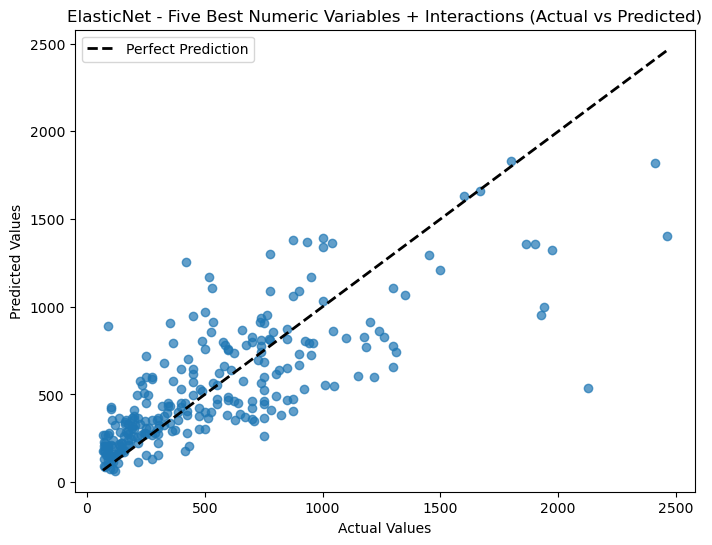

In [25]:
import matplotlib.pyplot as plt

# best performing feature set and model based on MSE
best_result = results_df.sort_values(by="MSE").iloc[0]
best_feature_set_name = best_result["Feature Set"]
best_model_name = best_result["Model"]
print(f"Best Model: {best_model_name} with Feature Set: {best_feature_set_name}")

# best feature set
if best_feature_set_name == "One Best Numeric Variable":
    X_best = X_one_best_numeric
elif best_feature_set_name == "Five Best Numeric Variables":
    X_best = X_five_best_numeric
elif best_feature_set_name == "Five Best Numeric Variables + Interactions":
    X_best = X_with_interactions
else:
    raise ValueError("Unexpected feature set name")

# fit the best model on the full dataset
if best_model_name == "Linear":
    best_model = LinearRegression()
elif best_model_name == "Ridge":
    best_model = Ridge(alpha=1) 
elif best_model_name == "Lasso":
    best_model = Lasso(alpha=1) 
elif best_model_name == "ElasticNet":
    best_model = ElasticNet(alpha=1, l1_ratio=0.5) 
else:
    raise ValueError("Unexpected model name")

# fit the model
best_model.fit(X_best, y)

# predictions
y_pred = best_model.predict(X_best)

# results
mse = mean_squared_error(y, y_pred)
print(f"\nFinal Model Summary:")
print(f"Model: {best_model_name}")
print(f"Feature Set: {best_feature_set_name}")
print(f"Mean Squared Error on full dataset: {mse:.2f}")

# actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, label="Perfect Prediction")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"{best_model_name} - {best_feature_set_name} (Actual vs Predicted)")
plt.legend()
plt.show()


The best performing model is the Elastic Net model that uses the feature set of the five best numeric variables plus interactions.The low value of 80204.62 for the MSE which a good representation of the model. The plot shows that the model generally predicts on the dataset well even though there is some spread which indicates that the model is not overfitting. 

## Appendix and References


Generative A.I. Statement: Chat-GPT was used to suggest changes in code to debug errors. An example of errors include, incorrect syntax, incorrect usage of parameters for plots, making suggestions to fix parameters to resolve the error in code. Chat-GPT was only used to resolve errors in already hand written code. 